## 평가환경 및 장비

In [16]:
import tensorflow as tf
import numpy as np
print("HW: ")
!nvidia-smi --query-gpu=name --format=csv,noheader
print("\nOS: ")
!cat /etc/*release | grep "DESCRIPTION"
print("\nDeep learning library : ")
print(tf.__version__)
print("\nMemory : ")
!free -h 

HW: 
NVIDIA GeForce RTX 2080

OS: 
DISTRIB_DESCRIPTION="Ubuntu 20.04.6 LTS"

Deep learning library : 
2.8.0

Memory : 
              total        used        free      shared  buff/cache   available
Mem:           62Gi       6.0Gi        36Gi        28Mi        20Gi        56Gi
Swap:         2.0Gi        54Mi       1.9Gi


## 데이터 및 모델 불러오기

In [17]:
from model.load_model import get_trained_model_ckpt, get_trained_model_h5
from utils.load_data import get_datasets, get_datasets_np
from utils.utils import set_seed

model_configs = {
  "impute": 1,
  "drop_rate": 0.4,
  "num_units": 8,
  "num_layer": 3,
  "regularize": 0.01,
  "learning_rate": 0.001,
  "label_smoothing": 0.2,
  "class_weight": 0,
  "batch_size": 128,
  "epochs": 20,
  "input_shape": [6,25],
  "isAttention":0
}


set_seed(0)

origin_model = get_trained_model_h5()
model = get_trained_model_ckpt('logs/tuning_0.1',configs=model_configs,epoch=None)
X,Y, class_weights = get_datasets_np(tuning=True)

print(len(X))

idx=6 
# 0 mimic-trian, 1 mimic-valid, 2 KU-ICU, 3 KU-COVID, 4 KU-ICU-3rd year, 5 KU-ICU-tuning, 6 KU-ICU-test
#  
X_KU_ICU = X[idx][:, :, :-5]
Y_KU_ICU = Y[idx]

# origin_model.evaluate(X_KU_ICU,Y_KU_ICU)
# model.evaluate(X_KU_ICU,Y_KU_ICU)

origin_pred = origin_model.predict(X_KU_ICU)
pred = model.predict(X_KU_ICU)

loading pretrained model from ./logs/best_model/lstm_dp04.h5
loading pretrained model from logs/tuning_0.1/checkpoint/run_158
Model: "severity_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 25)]           0         
                                                                 
 dropout_4 (Dropout)         (None, 6, 25)             0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 6, 16)            2176      
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 6, 16)             0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 6, 16)            1600      
 nal)                                                

In [18]:
from sklearn.metrics import roc_auc_score, average_precision_score,accuracy_score

columns = ['Rox', 'MEWS', 'NEWS', 'Sofa', 'MV-EWS', 'MV-EWS-FT']
y_probs = []
total_auc = []
total_ap = []
total_acc = []


def sigmoid(lst):
    return 1 / (1 + np.exp(-np.array(lst)))


for i in range(len(columns)):
    if i == 0 : # rox index
        y_prob = 1-sigmoid(X[idx][:,-1,-5+i])
    elif i < len(columns)-2:
        y_prob = sigmoid(X[idx][:,-1,-5+i])
    elif i == len(columns)-2:
        y_prob = origin_model.predict(X_KU_ICU)
    else:
        y_prob = model.predict(X_KU_ICU)
    
    y_probs.append(y_prob)
    y_pred = np.where(np.array(y_prob) >= 0.5, 1, 0)

    total_auc.append(roc_auc_score(Y[idx], y_prob, average=None))
    total_ap.append(average_precision_score(Y[idx], y_prob))
    total_acc.append(accuracy_score(Y[idx], y_pred))

print(columns)
print(total_auc)
print(total_ap)
print(total_acc)

['Rox', 'MEWS', 'NEWS', 'Sofa', 'MV-EWS', 'MV-EWS-FT']
[0.7425283806348657, 0.6769888289960205, 0.709905680677196, 0.6987926842766499, 0.7974864952129603, 0.8701072664143208]
[0.05061828325887155, 0.029878887640163387, 0.03710423791274712, 0.04551635147092142, 0.06269750064775138, 0.14585506130958664]
[0.9890310786106032, 0.010968921389396709, 0.010968921389396709, 0.010968921389396709, 0.8580230792296606, 0.9312652950678545]


In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score
fpr_list = []
tpr_list = []
auc_list = []
precision_list = []
recall_list = []
auprc_list = []

for i in range(len(columns)):
    fpr, tpr, _ = roc_curve(Y[idx], y_probs[i])
    pr, rec, _ = precision_recall_curve(Y[idx], y_probs[i])
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc(fpr,tpr))
    precision_list.append(pr)
    recall_list.append(rec)
    auprc_list.append(auc(rec,pr))

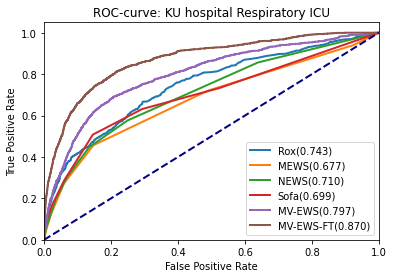

In [24]:
plt.figure()
lw = 2
columns = ['Rox', 'MEWS', 'NEWS', 'Sofa', 'MV-EWS', 'MV-EWS-FT']
for i in range(len(columns)):
    plt.plot(
        fpr_list[i],
        tpr_list[i],
        lw=lw,
        label=columns[i] + "(%0.3f)" %  round(auc_list[i], 3)
    )

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-curve: KU hospital Respiratory ICU")
plt.legend(loc="lower right")
plt.show()

In [38]:
auc_list

[0.7425283806348657,
 0.6769888289960205,
 0.709905680677196,
 0.6987926842766499,
 0.7974864952129603,
 0.8701072664143208]

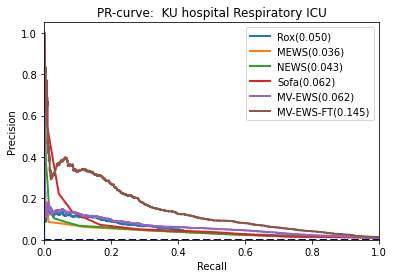

In [25]:
plt.figure()
lw = 2

for i in range(len(columns)):
    plt.plot(
        recall_list[i],
        precision_list[i],
        lw=lw,
        label=columns[i] + " (%0.3f)" %  round(auprc_list[i], 3)
    )
plt.plot([0, 1], [0, 0], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-curve:  KU hospital Respiratory ICU")
plt.legend(loc="upper right")
plt.show()

In [22]:
print("Predict severity of patients using MV-EWS Model...")

data_folds = np.array_split(X_KU_ICU, 10)
label_folds = np.array_split(Y_KU_ICU, 10)
average_accuracy = 0
for i,(data,label) in enumerate(zip(data_folds,label_folds)):
    print(f"\nPredicting on {i} fold")
    prob = model.predict(data,verbose=True)
    pred=np.where(prob>0.5,1,0)
    acc = accuracy_score(label, pred)
    average_accuracy = average_accuracy + acc
    print(f"Accuracy: {acc*100:.4f}")

print(f"\nMV-EWS 모델 평균 정확도: {average_accuracy*10:.4f}")
# print("\nMV-EWS 모델 평균 정확도: %0.4f" % (average_accuracy/10)*100)


Predict severity of patients using MV-EWS Model...

Predicting on 0 fold
  1/324 [..............................] - ETA: 4s

324/324 [==============================] - 1s 2ms/step
Accuracy: 92.6782

Predicting on 1 fold
324/324 [==============================] - 1s 2ms/step
Accuracy: 93.3166

Predicting on 2 fold
324/324 [==============================] - 1s 2ms/step
Accuracy: 93.0554

Predicting on 3 fold
324/324 [==============================] - 1s 2ms/step
Accuracy: 92.9967

Predicting on 4 fold
324/324 [==============================] - 1s 2ms/step
Accuracy: 93.0838

Predicting on 5 fold
324/324 [==============================] - 1s 2ms/step
Accuracy: 93.6932

Predicting on 6 fold
324/324 [==============================] - 1s 2ms/step
Accuracy: 93.0547

Predicting on 7 fold
324/324 [==============================] - 1s 2ms/step
Accuracy: 93.2289

Predicting on 8 fold
324/324 [==============================] - 1s 2ms/step
Accuracy: 93.0064

Predicting on 9 fold
324/324 [==============================] - 1s 2ms/step
Accuracy: 93.1515

MV-EWS 모델 평균 정확도: 93.1265


In [23]:
X_KU_ICU = X[idx][:, :, :-5]
Y_KU_ICU = Y[idx]
model.evaluate(X_KU_ICU,Y_KU_ICU)
pred = model.predict(X_KU_ICU)
total_acc.append(accuracy_score(Y[idx], y_pred))

3231/3231 [==============================] - 10s 3ms/step - loss: 0.4024 - auc: 0.8698 - ap: 0.1454


In [ ]:
asdf

In [39]:
def sigmoid(lst):
    return 1 / (1 + np.exp(-np.array(lst)))


total_auc = []

for idx in [1,6,3,4]:
    auc = []
    for i in range(len(columns)):
        if i == 0 : # rox index
            y_prob = 1-sigmoid(X[idx][:,-1,-5+i])
        elif i < len(columns)-2:
            y_prob = sigmoid(X[idx][:,-1,-5+i])
        elif i == len(columns)-2:
            y_prob = origin_model.predict(X[idx][:, :, :-5])
        else:
            y_prob = model.predict(X[idx][:, :, :-5])
        
        auc.append(roc_auc_score(Y[idx], y_prob, average=None))
    total_auc.append(auc)
    
results = np.array(total_auc)

In [72]:
results = np.array(total_auc)

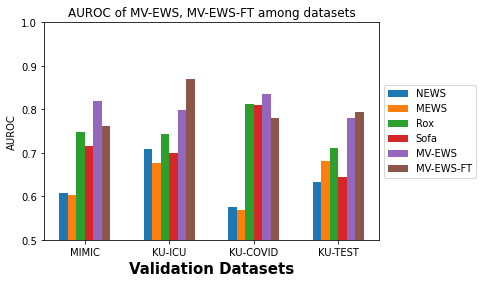

In [75]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Suppose the four values are:

# MIMIC: 0.819’, ‘KU-ICU: 0.792', ‘KU-COVID: 0.835', ‘KU-ICU-test: 0.779’
# ‘MIMIC: 0.798’, ‘KU-ICU: 0.819', ‘KU-COVID: 0.826', ‘KU-ICU-test: 0.793’

methods = ['Rox', 'MEWS', 'NEWS', 'Sofa', 'MV-EWS', 'MV-EWS-FT']
datasets = ['MIMIC', 'KU-ICU', 'KU-COVID', 'KU-TEST']

new_order = [2, 1, 0, 3, 4, 5]  # A new order for the methods (swap A and C here)
methods = [methods[i] for i in new_order]
results = results[:, new_order]

num_datasets = len(datasets)
num_methods = len(methods)

bar_width = 0.1  # adjust as needed to fit the plot
indices = np.arange(num_datasets)

for i in range(num_methods):
    plt.bar(indices + i*bar_width, results[:, i], width=bar_width, label=methods[i])

# Adding xticks
plt.xticks(indices + bar_width*(num_methods-1)/2, datasets)

plt.xlabel('Validation Datasets', fontweight='bold', fontsize=15)
plt.ylabel('AUROC')
plt.title('AUROC of MV-EWS, MV-EWS-FT among datasets')

# Set y-axis range
plt.ylim(0.5, 1)

# plt.legend()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Suppose the four values are:

# MIMIC: 0.819’, ‘KU-ICU: 0.792', ‘KU-COVID: 0.835', ‘KU-ICU-test: 0.779’
# ‘MIMIC: 0.798’, ‘KU-ICU: 0.819', ‘KU-COVID: 0.826', ‘KU-ICU-test: 0.793’

methods = ['Rox', 'MEWS', 'NEWS', 'Sofa', 'MV-EWS', 'MV-EWS-FT']
datasets = ['MIMIC', 'KU-ICU', 'KU-COVID', 'KU-TEST']

results  = np.array([
    [0.819, 0.792, 0.835, 0.779],
    [0.798, 0.819, 0.826, 0.793],
])

# position of bars on x axis
barWidth = 0.25
r1 = np.arange(len(datasets))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, results[0], color='b', width=barWidth, edgecolor='black', label=methods[0])
plt.bar(r2, results[1], color='g', width=barWidth, edgecolor='black', label=methods[1])

# Adding xticks
plt.xlabel('Validation Datasets', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth/2 for r in range(len(datasets))], datasets)
plt.ylabel('AUROC')
plt.title('AUROC of MV-EWS, MV-EWS-FT among datasets')

# Set y-axis range
plt.ylim(0, 1)

plt.legend()
plt.show()